<a href="https://colab.research.google.com/github/AhmadJamal01/Floodead-Inside/blob/main/Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import numpy as np
import pandas as pd
import glob
from scipy.cluster import vq
import cv2
import matplotlib.pyplot as plt

## Read Data

In [2]:
from google.colab import drive
import zipfile

# Mount your Google Drive
drive.mount('/content/drive')

# Specify the path to your zip file in Google Drive
zip_path = '/content/drive/MyDrive/dataset.zip'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/') 

# Access the extracted files
path = '/content/dataset/dataset/' 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.DataFrame(columns=['image_path', 'label'])

for image_path in sorted(glob.glob('dataset/flooded/*.jpg')):
    data = {'image_path': image_path, 'label': 'flooded'}
    df.loc[len(df)] = data

for image_path in sorted(glob.glob('dataset/non-flooded/*.jpg')):
    data = {'image_path': image_path, 'label': 'non-flooded'}
    df.loc[len(df)] = data

In [4]:
df.head()

,image_path,label
0,dataset/flooded/0.jpg,flooded
1,dataset/flooded/1.jpg,flooded
2,dataset/flooded/10.jpg,flooded
3,dataset/flooded/100.jpg,flooded
4,dataset/flooded/101.jpg,flooded


## Sample Data

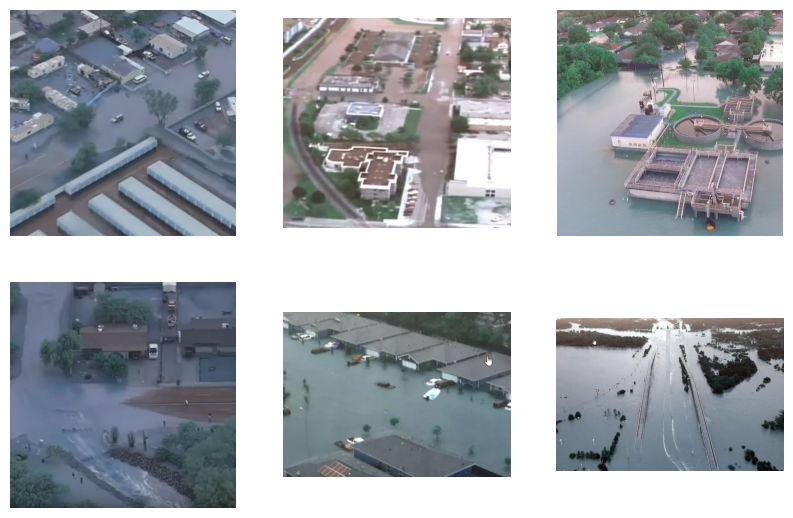

In [5]:
import cv2

flooded = df[df['label'] == 'flooded']
num_sample = 2

# List of image paths
hard_coded_image_paths = [
    "dataset/flooded/105.jpg", 
    "dataset/flooded/442.jpg",
    "dataset/flooded/267.jpg",
    "dataset/flooded/443.jpg"
]
# Randomly select a few sample images
sample_images = flooded.sample(n=num_sample) 
for img in hard_coded_image_paths:
  sample_images.loc[len(sample_images)] = img

num_images = len(sample_images)

def display_sample_images(image_paths):
    # Display the sample images
    plt.figure(figsize=(10, 10))
    for i, (_, row) in enumerate(sample_images.iterrows()):
        image = cv2.imread(row['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(num_images//2, num_images//2, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()


# Display the sample images
display_sample_images(sample_images)

# List of image paths to process
image_paths = sample_images['image_path'].tolist()

## Simple K-means

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sklearn.metrics import silhouette_score

def process_image(image_path, evaluate=False):
    # Read the image
    image = cv2.imread(image_path)

    # Set k-means criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 1.0)
    k = 2

    # Reshape the image into a 2D array of pixels and 3 color values (RGB)
    pixel_vals = image.reshape((-1, 3))
    pixel_vals = np.float32(pixel_vals)

    try:
        # Perform k-means clustering
        _, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 300, cv2.KMEANS_PP_CENTERS)

        # evaluate clusters
        if evaluate:
          silhouette_coefficient = silhouette_score(pixel_vals, labels.flatten())
        else:
          silhouette_coefficient = -99

        labels = labels.flatten()
        percentage = labels.sum() / len(labels)
        if percentage <= 0.5:
            most_represented_label = 0
        else:
            most_represented_label = 1

        # Convert data into 8-bit values
        centers = np.uint8(centers)
        centers[1 - most_represented_label] = [0, 0, 0]
        centers[most_represented_label] = [0, 105, 148]
        segmented_data = centers[labels]

        # Reshape data into the original image dimensions
        segmented_image = segmented_data.reshape(image.shape)

        return image, segmented_image, silhouette_coefficient

    except Exception as e:
        # Handle exception if error occurs during image processing
        print(f"Error processing image: {image_path}. Error: {e}")
        return None, None

def display_images(image, segmented_image, image_path):
    # Create subplots for original and segmented images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Show the original image
    axes[0].imshow(image)
    axes[0].axis('off')

    # Show the segmented image
    axes[1].imshow(segmented_image)
    axes[1].axis('off')

    plt.title(f'image:{image_path}')

    # Display the images
    plt.show()

# Plot all at once, you would change display_images to accept a list of tuples
# def process_images_parallel(image_paths):
#     with Pool() as pool:
#         images = pool.map(process_image, image_paths)
#         display_images(images)
# Plot each pair when they finish
def process_images_parallel(image_paths, evaluate=False):
    with Pool() as pool:
        for image_path in image_paths:
            image, segmented_image, silhouette_coefficients = pool.apply(process_image, (image_path,evaluate))
            if evaluate:
              print(f"Image: {image_path}, Silhouette Coefficient: {silhouette_coefficients}") 
            display_images(image, segmented_image, image_path)




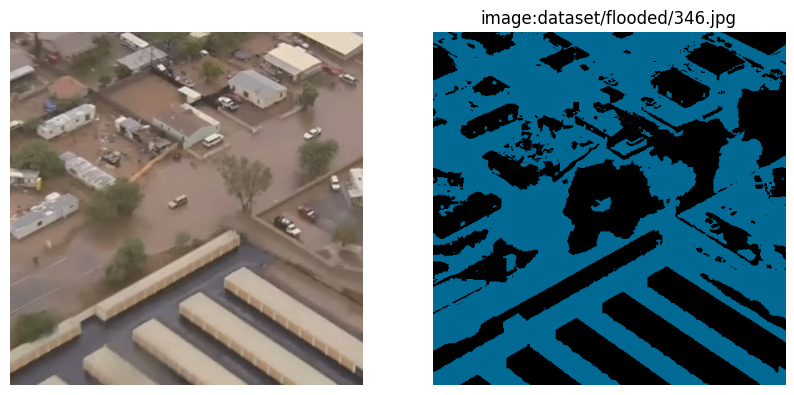

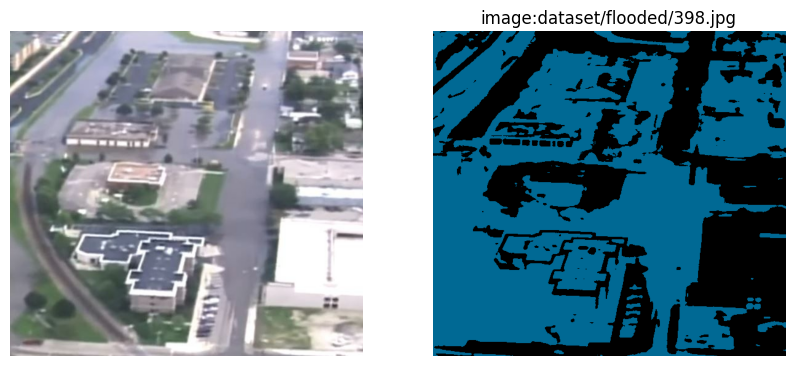

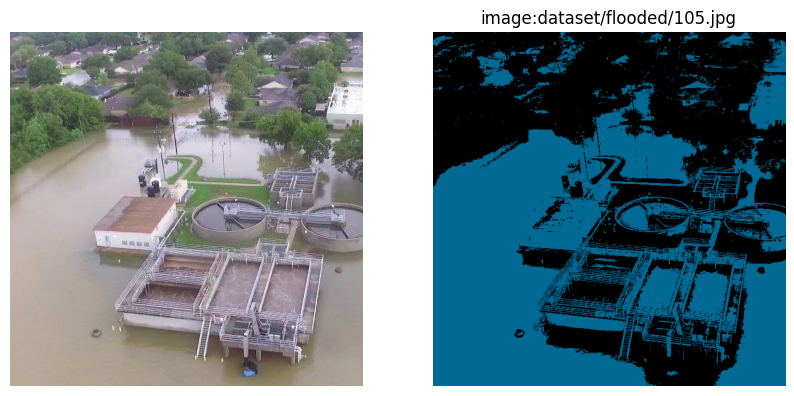

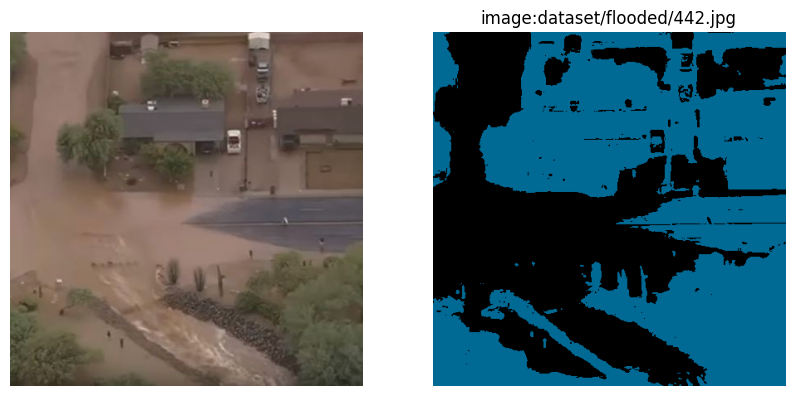

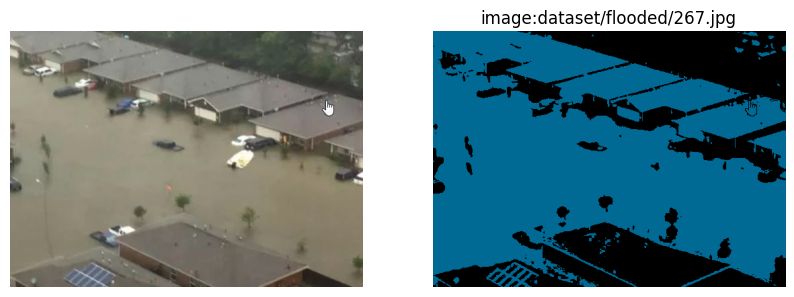

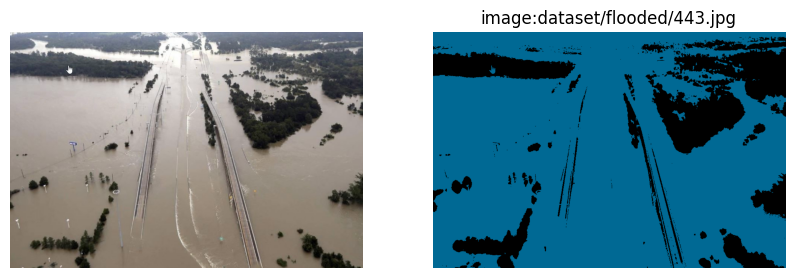

In [7]:
# Process images in parallel
process_images_parallel(image_paths)


Image: dataset/flooded/346.jpg, Silhouette Coefficient: 0.5311649441719055


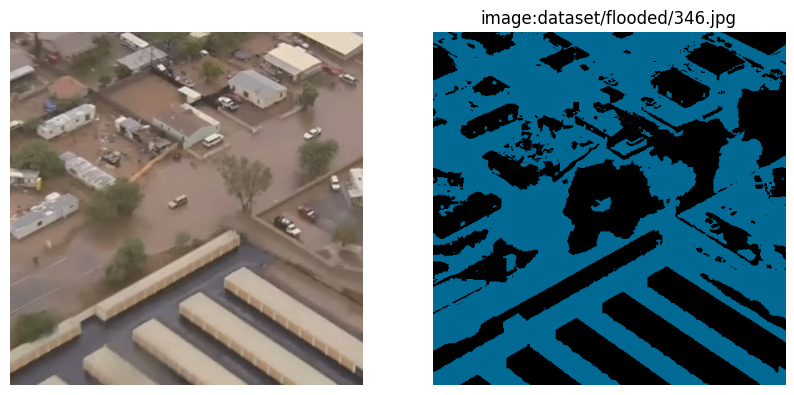

In [8]:
# Very computeionally expensive, test on one image only
eval_image_paths = [image_paths[0]]
# Process images in parallel
process_images_parallel(eval_image_paths, evaluate=True)